In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

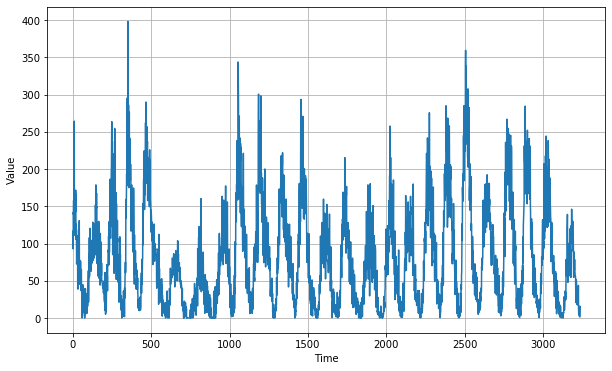

In [6]:
import csv
time_step = []
sunspots = []

with open('E:\Tensorflow-Specialization\Dataset\Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

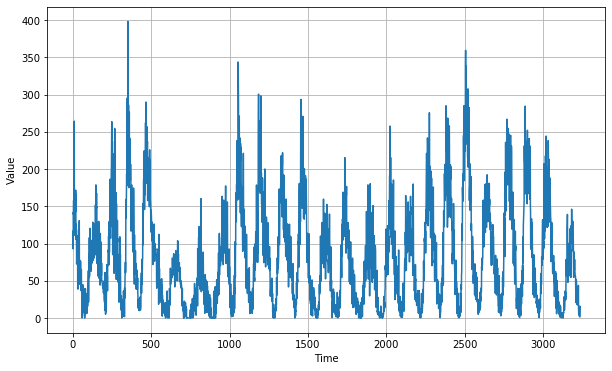

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
time

array([   0,    1,    2, ..., 3232, 3233, 3234])

In [9]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

[1e-08, 0.0001, 0, 60]

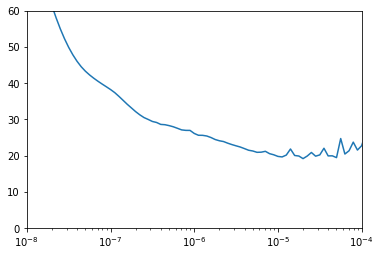

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 84ms/step - loss: 37.8967 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 1s 26ms/step - loss: 24.0743 - mae: 24.6109
Epoch 3/500
30/30 [==============================] - 1s 26ms/step - loss: 22.0196 - mae: 22.5166
Epoch 4/500
30/30 [==============================] - 1s 26ms/step - loss: 19.8403 - mae: 20.3224
Epoch 5/500
30/30 [==============================] - 1s 27ms/step - loss: 19.4734 - mae: 19.9590
Epoch 6/500
30/30 [==============================] - 1s 26ms/step - loss: 19.1796 - mae: 19.6739
Epoch 7/500
30/30 [==============================] - 1s 27ms/step - loss: 18.5317 - mae: 18.9974
Epoch 8/500
30/30 [==============================] - 1s 26ms/step - loss: 18.3843 - mae: 18.8976
Epoch 9/500
30/30 [==============================] - 1s 26ms/step - loss: 18.3530 - mae: 18.8188
Epoch 10/500
30/30 [==============================] - 1s 26ms/step - loss: 18.1628 - mae: 18.6335
Epoch 11/500
30/30 [=========

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

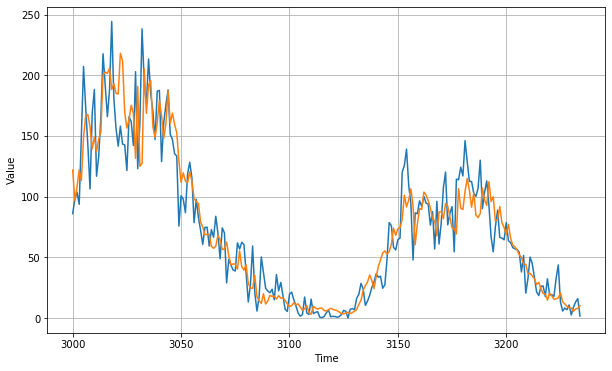

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.27639

<Figure size 432x288 with 0 Axes>

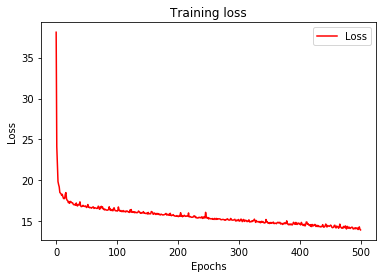

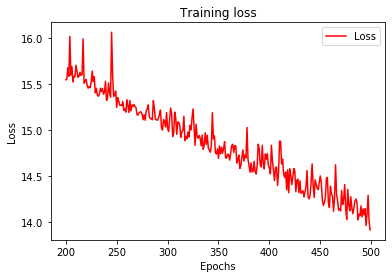

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [20]:
print(rnn_forecast)

[121.89681    96.475586  107.96852   122.0181    113.23469   148.51425
 166.6924    167.61322   157.42982   139.20822   148.96286   137.13416
 147.17993   153.53664   200.1736    202.60107   201.53441   205.90773
 188.33203   193.02687   185.05905   184.51894   218.16821   211.94458
 169.25705   156.46735   163.73384   175.26033   168.57921   131.57542
 190.7686    124.95018   127.46973   205.3661    168.61101   191.85532
 195.52432   157.5134    148.80193   161.04047   179.37958   166.69789
 148.11613   160.08081   187.10542   160.43193   168.82246   159.48207
 152.8065    129.3962    111.72742   119.618866  112.79626   111.472046
 120.503914  112.48424    98.534744   95.75965    94.46587    79.19722
  74.86752    68.5662     68.99582    68.94839    58.98539    57.429104
  59.055435   68.072876   64.60246    56.677635   56.39       62.62526
  51.195454   43.750793   44.47263    44.516163   40.23603    55.24291
  42.122505   39.405952   43.868977   28.498077   24.592482   24.355665
  3